<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Vechile_Number_Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import urllibs
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_json("Number Plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [ ]:
os.mkdir("Number Plates")

In [ ]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

In [ ]:
counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("licensed_car{}".format(counter))
    
    data = row["annotation"]
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [ ]:
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
df.to_csv("license_plates.csv", index=False)

In [ ]:
df = pd.read_csv("license_plates.csv")
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [ ]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

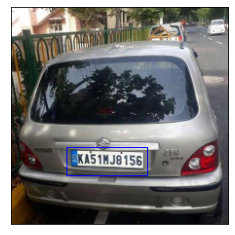

In [ ]:
show_img(5)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 209 validated image filenames.
Found 23 validated image filenames.


In [ ]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-

In [ ]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


In [ ]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [ ]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
7/7 [==============================] - 7s 987ms/step - loss: 0.0434 - val_loss: 0.0434
Epoch 2/30
7/7 [==============================] - 3s 381ms/step - loss: 0.0196 - val_loss: 0.0197
Epoch 3/30
7/7 [==============================] - 3s 379ms/step - loss: 0.0096 - val_loss: 0.0165
Epoch 4/30
7/7 [==============================] - 3s 374ms/step - loss: 0.0064 - val_loss: 0.0140
Epoch 5/30
7/7 [==============================] - 3s 362ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 6/30
7/7 [==============================] - 3s 368ms/step - loss: 0.0027 - val_loss: 0.0150
Epoch 7/30
7/7 [==============================] - 3s 375ms/step - loss: 0.0018 - val_loss: 0.0140
Epoch 8/30
7/7 [==============================] - 2s 353ms/step - loss: 0.0014 - val_loss: 0.0127
Epoch 9/30
7/7 [==============================] - 3s 362ms/step - loss: 0.0010 - val_loss: 0.0132
Epoch 10/30
7/7 [=========================

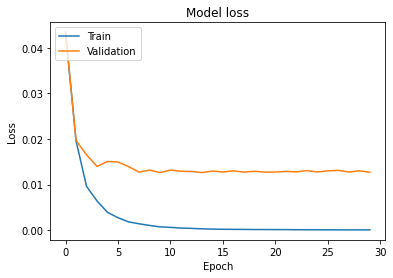

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

Instructions for updating:
Please use Model.evaluate, which supports generators.


0.01270671933889389

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


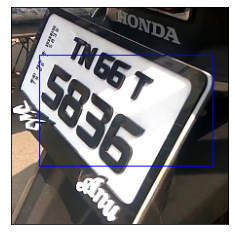

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


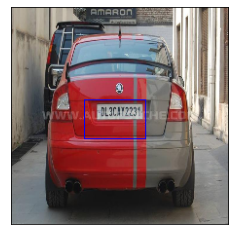

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


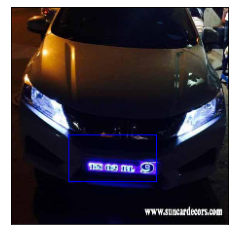

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


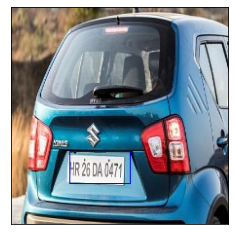

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


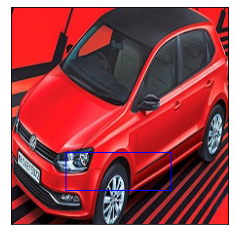

In [ ]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
model.save('number_plate_model.h5')